In [1]:
import torch
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # its VERY IMPORTANT this says cuda
print(DEVICE)
import torchaudio
from torch.utils.data import Dataset, DataLoader, Subset, random_split
import torch.nn as nn
import torch.nn.functional as F


from pathlib import Path
import matplotlib.pyplot as plt
from IPython.display import Audio
import math
import os
from torchinfo import summary
import json
from itertools import product
import time
import re
import shutil
import soundfile as sf 

cuda


# Dataset creation

#### Dataset

In [2]:
class WavDataset(Dataset):
    """
    A dataset that lazily loads WAV files from
    x directory and y directory from a list
    with the relative paths of the files.
    
    Args:
        x_files, y_files
    
    Returns:
        waveform (torch.Tensor): Tensor containing the waveform.
        filename (str): Name of the file without the extension.
        
    """
    
    def __init__(self, x_files, y_files):
        assert len(x_files) == len(y_files), "Inputs and targets must match"
        self.x_files = x_files
        self.y_files = y_files
        
    def __len__(self):
        return len(self.x_files)
    
    def __getitem__(self, index):
        wav_path = self.x_files[index]
        waveform_x, _ = torchaudio.load(wav_path)
        filename_x = wav_path.stem

        wav_path = self.y_files[index]
        waveform_y, _ = torchaudio.load(wav_path)
        filename_y = wav_path.stem

        return waveform_x, filename_x, waveform_y, filename_y


## Dataset analysis
| Training Dataset (s) | Test Dataset (s) | Range | Noise |
| - | - | - | - |
| Max: 15.11 <br> Min: 1.09 <br> Avg: 2.92 | Max: 9.76 <br> Min: 1.23 <br> Avg: 2.51 | Waveforms normalized to [-1,1] | Noise is real, not randomly generated|

#### Conclusion

If padding was applied to 20 s (20*48000=960000), tensors would be too big, need to downsample to 16kHz, no need to normalize data, the model must be able to handle this type of noise.

In [3]:
# dataset_dir = "../data/clean_trainset_28spk_wav"
# dataset = WavDataset(dataset_dir)
# loader = DataLoader(dataset, batch_size=1, num_workers=1,shuffle=False)

# def analysis(x):
#     return len(x[0].squeeze())/48000

# lengths = []
# for batch in loader:
#     lengths.append(analysis(batch))

# print('Training Dataset')
# print('Max length',max(lengths))
# print('Min length',min(lengths))
# print('Avg length',sum(lengths)/len(lengths))

In [4]:
# dataset_dir = "../data/clean_testset_wav"
# dataset = WavDataset(dataset_dir)
# loader = DataLoader(dataset, batch_size=1, num_workers=1,shuffle=False)

# lengths = []
# for batch in loader:
#     lengths.append(analysis(batch))
    
# print('Test Dataset')
# print('Max length',max(lengths))
# print('Min length',min(lengths))
# print('Avg length',sum(lengths)/len(lengths))

In [5]:
# clean_dataset_dir = "../data/clean_testset_wav"
# clean_dataset = WavDataset(clean_dataset_dir)
# clean_wav = clean_dataset[0][0].squeeze()

# noisy_dataset_dir = "../data/noisy_testset_wav"
# noisy_dataset = WavDataset(noisy_dataset_dir)
# noisy_wav = noisy_dataset[0][0].squeeze()

# fig, ax = plt.subplots(1, 2, figsize=(8, 4))

# ax[0].plot(clean_wav)
# ax[0].set_title("Clean Audio")

# ax[1].plot(noisy_wav)
# ax[1].set_title("Noisy Audio")

# plt.show()

# display(Audio(clean_wav, rate=48000))
# display(Audio(noisy_wav, rate=48000))

## Train/Val/Test Split


#### Resampling by rate and filter by duration

In [6]:
SRC_ROOT_48K = Path("../data")          # original 48 kHz root
DST_ROOT_16K = Path("../data_16k")      # downsampled root
FREQ = 16000                            # target sample rate
SECONDS = 3.2                           # max duration to keep (seconds)

FOLDERS = [
    "clean_trainset_28spk_wav",
    "noisy_trainset_28spk_wav",
    "clean_testset_wav",
    "noisy_testset_wav",
]


# ---------- STEP 1: DOWNSAMPLING ----------
def resample_folder_by_rate(src_dir: Path, dst_dir: Path, target_sr: int = FREQ):
    dst_dir.mkdir(parents=True, exist_ok=True)

    example_files = list(src_dir.glob("*.wav"))
    if not example_files:
        print(f"[WARN] No wav files in {src_dir}")
        return

    _, orig_sr = torchaudio.load(example_files[0])
    if orig_sr == target_sr:
        print(f"[INFO] {src_dir} already at {orig_sr} Hz, copying as-is.")
        resampler = None
    else:
        print(f"[INFO] Resampling {src_dir} from {orig_sr} Hz to {target_sr} Hz")
        resampler = torchaudio.transforms.Resample(orig_sr, target_sr)

    for wav_path in sorted(src_dir.glob("*.wav")):
        dst_path = dst_dir / wav_path.name

        if dst_path.exists():
            continue  # skip already processed

        waveform, sr = torchaudio.load(wav_path)
        if resampler is not None:
            waveform = resampler(waveform)

        torchaudio.save(dst_path, waveform, target_sr)

    print(f"[DONE] {src_dir} -> {dst_dir}")


def downsample_all():
    for folder in FOLDERS:
        src_dir = SRC_ROOT_48K / folder
        dst_dir = DST_ROOT_16K / folder
        if not src_dir.exists():
            print(f"[SKIP] Source directory not found: {src_dir}")
            continue
        resample_folder_by_rate(src_dir, dst_dir)


# ---------- STEP 2: FILTER BY DURATION (ON 16 kHz DATA) ----------
def filter_by_duration(src_dir: Path, max_duration_sec: float, target_sr: int = FREQ):
    """
    Returns list of wav files in src_dir with duration <= max_duration_sec
    and sample rate == target_sr.
    """
    wav_files = list(src_dir.glob("*.wav"))
    if not wav_files:
        print(f"[WARN] No wav files in {src_dir}")
        return []

    kept_files = []

    for wav_path in sorted(wav_files):
        try:
            info = sf.info(wav_path)
            duration = info.duration

            if info.samplerate != target_sr:
                print(f"[SKIP] {wav_path.name}: wrong SR {info.samplerate}, expected {target_sr}")
                continue
        except Exception as e:
            print(f"[ERROR] Could not read {wav_path}: {e}")
            continue

        if duration <= max_duration_sec:
            kept_files.append(wav_path)

    print(f"[DONE] {src_dir} | Kept {len(kept_files)}/{len(wav_files)} files")
    return kept_files


def build_kept_files_dict():
    """
    Runs duration filtering on the already-downsampled data_16k and
    returns a dict: {folder_name: [Path(...), ...], ...}
    """
    kept_files_by_folder = {}
    total_kept = 0
    total_files = 0

    for folder in FOLDERS:
        src_dir = DST_ROOT_16K / folder

        if not src_dir.exists():
            print(f"[SKIP] Source directory not found: {src_dir}")
            continue

        kept = filter_by_duration(src_dir, SECONDS, FREQ)
        kept_files_by_folder[folder] = kept
        total_kept += len(kept)
        total_files += len(list(src_dir.glob("*.wav")))

    print("\n=== SUMMARY ===")
    print(f"Total kept: {total_kept}/{total_files} files")

    return kept_files_by_folder


#### Dataloader: collate function, splitting function

In [7]:
def collate_fn(batch):
    # batch is a list of tuples:
    # (waveform_x, filename_x, waveform_y, filename_y)
    waveform_x_list, filename_x_list, waveform_y_list, filename_y_list = zip(*batch)

    # Assume torchaudio.load → waveform: [channels, samples]
    # Convert to [samples] (mono) by squeezing channel dim
    xs = [w.squeeze(0) for w in waveform_x_list]
    ys = [w.squeeze(0) for w in waveform_y_list]

    batch_size = len(xs)
    target_len = int(SECONDS * FREQ)

    # Allocate padded tensors [batch, target_len]
    x_padded = torch.zeros(batch_size, target_len)
    y_padded = torch.zeros(batch_size, target_len)

    # Truncate or pad each waveform
    for i, (x, y) in enumerate(zip(xs, ys)):
        x_len = min(x.shape[0], target_len)
        y_len = min(y.shape[0], target_len)

        x_padded[i, :x_len] = x[:x_len]
        y_padded[i, :y_len] = y[:y_len]

    # Add channel dimension: [batch, 1, target_len]
    x_padded = x_padded.unsqueeze(1)
    y_padded = y_padded.unsqueeze(1)

    return x_padded, y_padded, list(filename_x_list), list(filename_y_list)

def create_split(
    batch_size,
    num_workers,
    sample_size,
    noisy_train_files,
    clean_train_files,
    noisy_test_files,
    clean_test_files,
    ratio=0.9,
    seed=42,
):
    """
    Create train/val/test dataloaders from paired audio files.
    
    Args:
        batch_size: Batch size for DataLoader
        num_workers: Number of workers for DataLoader
        sample_size: Limit number of training samples (None = use all)
        noisy_train_files: List of noisy train file paths
        clean_train_files: List of clean train file paths
        noisy_test_files: List of noisy test file paths
        clean_test_files: List of clean test file paths
        ratio: Train/val split ratio (default 0.9)
        seed: Random seed for reproducibility
    
    Returns:
        train_loader, val_loader, test_loader
    """
    torch.manual_seed(seed)
    
    # Limit sample size if specified
    if sample_size is not None:
        actual_size = min(sample_size, len(noisy_train_files))
        noisy_train_files = noisy_train_files[:actual_size]
        clean_train_files = clean_train_files[:actual_size]
    
    # Train/val split
    train_size = int(ratio * len(noisy_train_files))
    indices = torch.randperm(len(noisy_train_files))
    train_indices = indices[:train_size]
    val_indices = indices[train_size:]
    
    # Split file lists (keeping pairs matched)
    x_train_files = [noisy_train_files[i] for i in train_indices]
    y_train_files = [clean_train_files[i] for i in train_indices]
    x_val_files = [noisy_train_files[i] for i in val_indices]
    y_val_files = [clean_train_files[i] for i in val_indices]
    
    # Create paired datasets
    train_dataset = WavDataset(x_train_files, y_train_files)
    val_dataset = WavDataset(x_val_files, y_val_files)
    test_dataset = WavDataset(noisy_test_files, clean_test_files)
    
    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        collate_fn=collate_fn,
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        collate_fn=collate_fn,
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        collate_fn=collate_fn,
    )
    
    return train_loader, val_loader, test_loader


# Denoising

## Models

In [8]:
class Wave_UNet(nn.Module):
    """
    Implements Wave-U-Net, meaning it employs 1D convolutions in a 
    encode-decode structure that takes raw audio and denoises it.
    It uses LeakyReLU as the activation function except 
    in the last layer which is tanh.

    To reduce noise artifacts, no transpose convolutions are used,
    and the convolutions are set to 0 padding. To compensate for
    this, the waveforms are padded with 0s. 

    Regarding how the time domain is shrunk and expanded, decimate
    is used for downsampling and a custom interpolation function is 
    usd for upsampling. Notably, it doesn't extrapolate, meaning
    the output is actually 2n-1 instead of the usual 2n.

    DISCLAIMER:
    A short waveform paired with a high depth will NOT work. Beware.
    """
    def __init__(self, depth=12, base_filters=24): # add transformation function
        super().__init__()
        self.depth = depth
        self.padding = self.compute_padding()

        # Encoder
        self.encoders = nn.ModuleList()
        in_ch = 1 
        for i in range(depth): # 0 -> depth-1
            out_ch = base_filters * (i + 1)
            self.encoders.append(self.EncoderBlock(in_ch, out_ch))
            in_ch = out_ch
        
        # Mid convolution, which has no decimation
        out_ch = in_ch+base_filters
        self.mid_conv = nn.Sequential(
            nn.Conv1d(in_ch, out_ch, kernel_size = 15, padding=0),
            nn.LeakyReLU()
        )
        in_ch = out_ch

        # Decoder
        self.decoders = nn.ModuleList()
        for i in range(depth-1, 0, -1): # depth-1 -> 1 for the staggered interpolation
            out_ch = base_filters * (i + 1)
            self.decoders.append(self.DecoderBlock(in_ch, out_ch, out_ch))
            in_ch = out_ch

        # staggered interpolation, fix this
        self.StaggeredBlock = nn.Sequential(
            nn.Upsample(scale_factor=2,mode='linear',align_corners=True),
            nn.Conv1d(in_ch+base_filters, base_filters, kernel_size = 15, padding=0),
            nn.LeakyReLU()
        )

        
        self.final_conv = nn.Conv1d(base_filters+1, 1, kernel_size=1, padding=0) # finale, kernel size 1 conv, from base_filters+1 -> 1
         
    def forward(self, x):
        original = x # for the finale
        x = F.pad(x, (self.padding, self.padding), mode='constant', value=0) 

        # DOWNSAMPLER
        skips = []
        for enc in self.encoders:
            x, skip = enc(x)
            skips.append(skip)

        x = self.mid_conv(x) # mid conv

        # UPSAMPLER
        for dec in self.decoders:
            skip = self.center_crop(skips.pop(),(x.shape[-1]*2)-1)
            x = dec(x, skip)

        # Staggered upsampler
        # add center crop
        skip = self.center_crop(skips.pop(), x.shape[-1])
        x = torch.cat([skip, x], dim=1)
        x = self.StaggeredBlock(x)
        
        x = self.center_crop(x, original.shape[-1])
        x = torch.cat([x, original], dim=1)
        x = self.final_conv(x) # finale + tanh activation function
        return x
    
    class EncoderBlock(nn.Module):
        def __init__(self, in_channels, out_channels):
            super().__init__()
            self.conv = nn.Conv1d(in_channels, out_channels, 
                                  kernel_size=15, padding=0) # padding_mode='zeros'
            self.leaky_relu = nn.LeakyReLU()
            self.decimate = Wave_UNet.Decimate2()

        def forward(self, x):
            x = self.conv(x)
            x = self.leaky_relu(x)
            skip = x
            x = self.decimate(x)
            return x, skip
        
    class DecoderBlock(nn.Module):
        def __init__(self, in_channels, skip_channels, out_channels):
            super().__init__()
            self.upsample = Wave_UNet.Interpolate2()
            self.conv = nn.Conv1d(in_channels+skip_channels, out_channels, 
                                    kernel_size=5, padding=0) 
            self.leaky_relu = nn.LeakyReLU()
            
        def forward(self, x, skip):
            x = self.upsample(x)
            x = torch.cat([x, skip], dim=1)
            x = self.conv(x)
            x = self.leaky_relu(x)
            return x
    
    class Decimate2(nn.Module): # cuts size in half by skipping every other step
        def __init__(self):
            super().__init__()
        def forward(self, x):
            return x[..., ::2]
    
    class Interpolate2(nn.Module): # it differs to Upsample by having a 2n-1 output size
        def __init__(self,):
            super().__init__()
        def forward(self, x):
            # remember, input is a batch
            T = x.shape[-1]
            out_shape = list(x.shape)
            out_shape[-1] = 2 * T - 1
            # calculate interpolation
            output = torch.empty(out_shape, device=x.device, dtype=x.dtype) 
            output[...,::2] = x
            output[...,1::2] = 0.5 * (x[..., :-1] + x[..., 1:])
            return output
        
    def compute_padding(self):
        # Makes a estimate of how much padding is needed on each side 
        # of each tendor to compensate for padding=0. 
        # Takes the reverse route of the Wave U-Net
        padding = 0 # initialize

        # UPSAMPLER
        # staggered interpolation
        padding += 4 # conv
        padding = math.ceil(padding/2) # interpolation

        for _ in range(self.depth-1):
            padding += 4 # conv
            padding = math.ceil((padding+1)/2 ) # interpolation

        padding += 14 # mid conv

        # DOWNSAMPLER
        for _ in range(self.depth):
            padding = 2*padding # decimate
            padding += 14 # conv
        
        return int(padding/2) # F.pad doesnt take float
    
    def center_crop(self, x, target_len):
        # x is (B, C, T), target_len is int
        current_len = x.shape[-1]
        diff = current_len - target_len
        if diff == 0: return x
        if diff < 0: raise ValueError("Target bigger than input!")
        start = diff // 2
        end = start + target_len
        return x[..., start:end]
    
     
    

In [9]:
class EncoderBlock(nn.Module):
    def __init__(self, in_ch, out_ch, dilation=1):
        super().__init__()
        self.conv1x1_in = nn.Conv2d(in_ch, out_ch, kernel_size=1, padding=0)
        self.conv3x3 = nn.Conv2d(
            out_ch, out_ch, kernel_size=3,
            padding=dilation, dilation=dilation
        )
        self.prelu = nn.PReLU()
        self.bn = nn.BatchNorm2d(out_ch)
        self.conv1x1_out = nn.Conv2d(out_ch, out_ch, kernel_size=1, padding=0)
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        x = self.conv1x1_in(x)
        x = self.conv3x3(x)
        x = self.prelu(x)
        x = self.bn(x)
        x = self.conv1x1_out(x)
        skip = x
        x = self.pool(x)
        return x, skip

class DecoderBlock(nn.Module):
    def __init__(self):
        super().__init__()
        # upconv will be set per block when UNet is built
        self.upconv = None
        self.conv1 = None
        self.bn1 = None
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = None
        self.bn2 = None
        self.relu2 = nn.ReLU(inplace=True)

    def center_crop(self, x, th, tw):
        h, w = x.shape[-2:]
        dh, dw = h - th, w - tw
        if dh == 0 and dw == 0:
            return x
        sh, sw = dh // 2, dw // 2
        return x[..., sh:sh+th, sw:sw+tw]

    def forward(self, x, skip):
        x = self.upconv(x)

        if x.shape[-2:] != skip.shape[-2:]:
            skip = self.center_crop(skip, x.shape[-2], x.shape[-1])

        x = torch.cat([x, skip], dim=1)             # (B, C_cat, H, W)
        C_cat = x.shape[1]

        # lazily build convs with correct channel sizes
        if self.conv1 is None:
            self.conv1 = nn.Conv2d(C_cat, C_cat, kernel_size=3, padding=1).to(x.device)
            self.bn1 = nn.BatchNorm2d(C_cat).to(x.device)
        if self.conv2 is None:
            out_ch = skip.shape[1]
            self.conv2 = nn.Conv2d(C_cat, out_ch, kernel_size=3, padding=1).to(x.device)
            self.bn2 = nn.BatchNorm2d(out_ch).to(x.device)

        x = self.conv1(x); x = self.relu1(x); x = self.bn1(x)
        x = self.conv2(x); x = self.relu2(x); x = self.bn2(x)
        return x

class UNet(nn.Module):
    def __init__(self, encoder_channels=None,
                 forward_transform=None,
                 inverse_transform=None):
        super().__init__()

        # default channels if none provided
        if encoder_channels is None:
            encoder_channels = [32, 64, 128, 256, 256, 512, 512]
        self.channels = encoder_channels

        # pluggable transforms (modules)
        assert forward_transform is not None
        assert inverse_transform is not None
        self.forward_transform = forward_transform
        self.inverse_transform = inverse_transform

        # Encoder
        self.encoders = nn.ModuleList()
        in_ch = 1
        for ch in self.channels:
            self.encoders.append(EncoderBlock(in_ch, ch))
            in_ch = ch

        # Decoder (one per encoder, using all skips)
        self.decoders = nn.ModuleList()
        dec_in_ch = self.channels[-1]
        skip_chs = self.channels
        for skip_ch in reversed(skip_chs):
            block = DecoderBlock()
            block.upconv = nn.ConvTranspose2d(dec_in_ch, dec_in_ch, kernel_size=2, stride=2)
            self.decoders.append(block)
            dec_in_ch = skip_ch

        self.final_conv = nn.Conv2d(dec_in_ch, 1, kernel_size=1, padding=0)

    def forward(self, noisy_waveform):
        # 1) generic forward transform: waveform -> aux, phase
        aux, phase = self.forward_transform(noisy_waveform)   # (B,1,F,T), phase

        B, C, F_orig, T_orig = aux.shape

        # 2) crop to multiple of 2^N (N=len(channels))
        div = 2 ** len(self.channels)
        F_crop = (F_orig // div) * div
        T_crop = (T_orig // div) * div
        aux_c = aux[:, :, :F_crop, :T_crop]

        # 3) U-Net
        x = aux_c
        skips = []
        for enc in self.encoders:
            x, skip = enc(x)
            skips.append(skip)

        for dec in self.decoders:
            x = dec(x, skips.pop())

        enh_aux_c = self.final_conv(x)    # (B,1,F_crop,T_crop)

        # 4) resize back
        enh_aux = F.interpolate(
            enh_aux_c,
            size=(F_orig, T_orig),
            mode="bilinear",
            align_corners=False,
        )

        # 5) inverse transform
        enhanced = self.inverse_transform(enh_aux, phase)
        return enhanced

#### U-Net modules

In [10]:
# STFT 
class STFTLogPower(nn.Module):
    def __init__(self, n_fft=1024, hop_length=160, win_length=400, eps=1e-12):
        super().__init__()
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.win_length = win_length
        self.eps = eps
        window = torch.hann_window(win_length)
        self.register_buffer("window", window)

    def forward(self, waveform):
        # waveform: (B,1,T)
        B, C, T = waveform.shape
        assert C == 1
        spec = torch.stft(
            waveform.squeeze(1),
            n_fft=self.n_fft,
            hop_length=self.hop_length,
            win_length=self.win_length,
            window=self.window,
            center=True,
            return_complex=True,
        )
        mag = spec.abs()
        aux = (mag ** 2 + self.eps).log()      # generic "aux" rep
        return aux.unsqueeze(1), spec          # (B,1,F,T), phase/spec

class ISTFTFromLogPower(nn.Module):
    def __init__(self, n_fft=1024, hop_length=160, win_length=400):
        super().__init__()
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.win_length = win_length
        window = torch.hann_window(win_length)
        self.register_buffer("window", window)

    def forward(self, aux, phase):
        # aux: log-power-like (B,1,F,T)
        mag = (aux.exp()).sqrt().squeeze(1)    # (B,F,T)
        complex_spec = mag * phase / (phase.abs() + 1e-12)
        wav = torch.istft(
            complex_spec,
            n_fft=self.n_fft,
            hop_length=self.hop_length,
            win_length=self.win_length,
            window=self.window,
            center=True,
        )
        return wav.unsqueeze(1)                # (B,1,T)

In [11]:
# log-mel
class MelLogMag(nn.Module):
    def __init__(self, sample_rate=16000,
                 n_fft=1024, hop_length=160, win_length=400,
                 n_mels=256, eps=1e-12):
        super().__init__()
        self.eps = eps
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.win_length = win_length
        self.window = torch.hann_window(win_length)
        self.mel = torchaudio.transforms.MelSpectrogram(
            sample_rate=sample_rate,
            n_fft=n_fft,
            hop_length=hop_length,
            win_length=win_length,
            n_mels=n_mels,
            power=2.0,
        )

    def forward(self, waveform):
        # waveform: (B,1,T)
        B, C, T = waveform.shape
        assert C == 1
        # 1) STFT for phase
        spec = torch.stft(
            waveform.squeeze(1),
            n_fft=self.n_fft,
            hop_length=self.hop_length,
            win_length=self.win_length,
            window=self.window.to(waveform.device),
            center=True,
            return_complex=True,
        )                           # (B, F, T_spec)

        # 2) Mel on waveform, not on spec
        mel = self.mel(waveform.squeeze(1))   # (B, n_mels, T_mel)
        aux = (mel + self.eps).log().unsqueeze(1)
        return aux, spec
         
    
class InvMelLogMag(nn.Module):
    def __init__(self, sample_rate=16000,
                 n_fft=1024, hop_length=160, win_length=400,
                 n_mels=256):
        super().__init__()
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.win_length = win_length
        self.window = torch.hann_window(win_length)
        self.mel_inv = torchaudio.transforms.InverseMelScale(
            n_stft=n_fft // 2 + 1,
            n_mels=n_mels,
            sample_rate=sample_rate,
        )

    def forward(self, aux, phase):
        # aux: (B,1,M,Tm)
        mel = (aux.squeeze(1).exp())          # (B,M,Tm)
        mag2 = self.mel_inv(mel)              # (B,F,T)
        mag = mag2.clamp(min=0).sqrt()
        complex_spec = mag * phase / (phase.abs() + 1e-12)
        wav = torch.istft(
            complex_spec,
            n_fft=self.n_fft,
            hop_length=self.hop_length,
            win_length=self.win_length,
            window=self.window.to(phase.device),
            center=True,
        )
        return wav.unsqueeze(1)


In [12]:
# MFCC‑like cepstrogram
class Cepstrogram(nn.Module):
    def __init__(self, sample_rate=16000,
                 n_fft=1024, hop_length=160, win_length=400,
                 n_mels=128, n_ceps=64, eps=1e-12):
        super().__init__()
        self.eps = eps
        self.stft = STFTLogPower(n_fft=n_fft,
                                 hop_length=hop_length,
                                 win_length=win_length,
                                 eps=eps)
        self.mel_fb = torchaudio.transforms.MelScale(
            n_mels=n_mels,
            sample_rate=sample_rate,
            n_stft=n_fft // 2 + 1,
        )
        self.n_ceps = n_ceps

    def forward(self, waveform):
        _, spec = self.stft(waveform)          # spec: (B,F,T)
        mag = spec.abs()
        mel = self.mel_fb(mag)                 # (B,M,T)
        log_mel = (mel + self.eps).log()
        # DCT-II along mel axis
        cep = torch.real(torch.fft.dct(log_mel, type=2, dim=1, norm='ortho'))
        cep = cep[:, :self.n_ceps, :]          # (B, n_ceps, T)
        return cep.unsqueeze(1), spec

class InvCepstrogram(nn.Module):
    def __init__(self, sample_rate=16000,
                 n_fft=1024, hop_length=160, win_length=400,
                 n_mels=128, n_ceps=64):
        super().__init__()
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.win_length = win_length
        window = torch.hann_window(win_length)
        self.register_buffer("window", window)

        fb = torchaudio.transforms.MelScale(
            n_mels=n_mels,
            sample_rate=sample_rate,
            n_stft=n_fft // 2 + 1,
        ).fb
        self.register_buffer("mel_inv", torch.pinverse(fb))
        self.n_mels = n_mels
        self.n_ceps = n_ceps

    def forward(self, aux, phase):
        mel = (aux.squeeze(1).exp()).sqrt()      # (B, M, T)
        mel = mel.permute(0, 2, 1)               # (B, T, M)
        mag = torch.matmul(mel, self.mel_inv.T)  # (B, T, n_stft)
        mag = mag.permute(0, 2, 1)               # (B, n_stft, T)

        complex_spec = mag * phase / (phase.abs() + 1e-12)
        wav = torch.istft(
            complex_spec,
            n_fft=self.n_fft,
            hop_length=self.hop_length,
            win_length=self.win_length,
            window=self.window,
            center=True,
        )
        return wav.unsqueeze(1)

In [13]:
# Log‑CQT magnitude
class CQTLogMag(nn.Module):
    def __init__(self, sample_rate=16000,
                 hop_length=160,
                 fmin=32.7, bins_per_octave=24, n_bins=256,
                 eps=1e-12):
        super().__init__()
        self.eps = eps
        self.cqt = torchaudio.transforms.CQT(
            sample_rate=sample_rate,
            hop_length=hop_length,
            fmin=fmin,
            n_bins=n_bins,
            bins_per_octave=bins_per_octave,
        )

    def forward(self, waveform):
        # waveform: (B,1,T)
        B, C, T = waveform.shape
        assert C == 1
        cqt = self.cqt(waveform.squeeze(1))    # (B, n_bins, T) complex
        mag = cqt.abs()
        aux = (mag ** 2 + self.eps).log()
        return aux.unsqueeze(1), cqt

class InvCQTLogMag(nn.Module):
    def __init__(self, sample_rate=16000,
                 hop_length=160,
                 fmin=32.7, bins_per_octave=24, n_bins=256):
        super().__init__()
        self.inv_cqt = torchaudio.transforms.InverseCQT(
            sample_rate=sample_rate,
            hop_length=hop_length,
            fmin=fmin,
            n_bins=n_bins,
            bins_per_octave=bins_per_octave,
        )

    def forward(self, aux, phase):
        mag = (aux.squeeze(1).exp()).sqrt()    # (B, n_bins, T)
        complex_cqt = mag * phase / (phase.abs() + 1e-12)
        wav = self.inv_cqt(complex_cqt)        # (B, T)
        return wav.unsqueeze(1)

## Training

#### Hyperparameters, Split creation

In [14]:
# ---------- CONFIG ----------
MODEL_DIR = Path("../model")
MODEL_DIR.mkdir(exist_ok=True)
HIST_DIR = Path("../history")
HIST_DIR.mkdir(exist_ok=True)

# Split parameters
batch_size = 16
num_workers = 4
sample_size = 64 # None = Use all files

# Training parameters
num_epochs = 5
print_every = 1
Loss = nn.L1Loss
LR = 1e-4
PATIENCE = 20 # epochs with no val improvement
min_delta = 0  # min difference

In [15]:
# Create Split
# Extract the lists
kept_files = build_kept_files_dict()
noisy_train_files = kept_files["noisy_trainset_28spk_wav"]
clean_train_files = kept_files["clean_trainset_28spk_wav"]
noisy_test_files = kept_files["noisy_testset_wav"]
clean_test_files = kept_files["clean_testset_wav"]

# Create actual split
train_loader, val_loader, test_loader = create_split(
    batch_size=batch_size,
    num_workers=num_workers,
    sample_size=sample_size,  
    noisy_train_files=noisy_train_files,
    clean_train_files=clean_train_files,
    noisy_test_files=noisy_test_files,
    clean_test_files=clean_test_files,
    ratio=0.9,
    seed=42,
)

test_run = next(iter(train_loader))
print()
print(test_run[2])
print(test_run[3])

[DONE] ../data_16k/clean_trainset_28spk_wav | Kept 8181/11572 files
[DONE] ../data_16k/noisy_trainset_28spk_wav | Kept 8181/11572 files
[DONE] ../data_16k/clean_testset_wav | Kept 689/824 files
[DONE] ../data_16k/noisy_testset_wav | Kept 689/824 files

=== SUMMARY ===
Total kept: 17740/24792 files

['p226_114', 'p226_109', 'p226_059', 'p226_032', 'p226_088', 'p226_097', 'p226_117', 'p226_063', 'p226_025', 'p226_111', 'p226_086', 'p226_092', 'p226_090', 'p226_065', 'p226_068', 'p226_074']
['p226_114', 'p226_109', 'p226_059', 'p226_032', 'p226_088', 'p226_097', 'p226_117', 'p226_063', 'p226_025', 'p226_111', 'p226_086', 'p226_092', 'p226_090', 'p226_065', 'p226_068', 'p226_074']


#### Training and testing functions

In [16]:
# ---------- TRAIN / VAL LOOP ----------
def run_one_epoch(model, loader, criterion, optimizer=None):
    """
    Run one epoch of training or validation.
    
    Args:
        model: Neural network model
        loader: DataLoader that yields (noisy, clean, filenames_x, filenames_y)
        criterion: Loss function
        optimizer: Optimizer (None for eval mode)
    
    Returns:
        avg_loss: Average loss over the epoch
    """
    if optimizer is None:
        model.eval()
    else:
        model.train()

    total_loss = 0.0
    n_batches = 0

    for noisy, clean, _, _ in loader:
        noisy = noisy.to(DEVICE)  # shape (B, 1, T)
        clean = clean.to(DEVICE)  # shape (B, 1, T)

        if optimizer is not None:
            optimizer.zero_grad()

        # Forward pass
        out = model(noisy)

        # Crop clean to match output length (in case of slight mismatch)
        T = out.shape[-1]
        clean_aligned = clean[..., :T]

        loss = criterion(out, clean_aligned)

        if optimizer is not None:
            loss.backward()
            optimizer.step()

        total_loss += loss.item()
        n_batches += 1

        # Free intermediate tensors
        del noisy, clean, clean_aligned, out, loss

    avg_loss = total_loss / max(n_batches, 1)
    return avg_loss


def train(
    model,
    criterion,
    train_loader,
    val_loader,
    num_epochs=200,
    print_every=10,
    model_filename="best.pt",
    learning_rate=0.0001,
    patience=20,
    min_delta = 0
):
    """
    Train model with early stopping.
    
    Args:
        model: Neural network model
        criterion: Loss function
        train_loader: Training DataLoader
        val_loader: Validation DataLoader
        num_epochs: Max number of epochs
        model_filename: Where to save best model
        print_every: Print stats every N epochs
    
    Returns:
        history: Dict with train_loss and val_loss lists
    """
    model.to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    best_val = float("inf")
    best_state = None
    epochs_no_improve = 0

    history = {
        "train_loss": [],
        "val_loss": [],
    }

    for epoch in range(1, num_epochs + 1):
        # Train
        train_loss = run_one_epoch(model, train_loader, criterion, optimizer)

        # Validation
        with torch.no_grad():
            val_loss = run_one_epoch(model, val_loader, criterion, optimizer=None)

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)

        if epoch % print_every == 0 or epoch == num_epochs:
            print(
                f"Epoch {epoch:03d} | train_loss={train_loss:.4f} | val_loss={val_loss:.4f}"
            )

        # Early stopping / best model tracking
        if abs(val_loss - best_val) > min_delta:
            best_val = val_loss
            best_state = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch}.")
            break

    # Save best model
    model_path = MODEL_DIR / model_filename
    if best_state is not None:
        torch.save(best_state, model_path)
        print(f"Best model (val_loss={best_val:.4f}) saved to {model_path}")

    return history


# ---------- TEST EVAL ----------
def evaluate_test(model, test_loader, criterion, model_filename="best.pt"):
    """
    Load best model from disk and evaluate on test set.
    
    Args:
        model: Model class (will be instantiated)
        test_loader: Test DataLoader
        criterion: Loss function
        model_filename: Path to saved model weights
    
    Returns:
        test_loss: Average loss on test set
    """
    model.to(DEVICE)
    model.eval()
    
    with torch.no_grad():
        test_loss = run_one_epoch(model, test_loader, criterion, optimizer=None)

    print(f"Test loss: {test_loss:.4f}")
    return test_loss

In [17]:
# EXTRA STUFF
# ---------- MODEL ----------ç
def load_model(model_filename, model):
    model_path = MODEL_DIR / model_filename
    state_dict = torch.load(model_path, map_location=DEVICE, weights_only=True)
    model.load_state_dict(state_dict)
    return model

# ---------- HISTORY ----------
def save_history(history, filename):
    hist_file = HIST_DIR / f"{filename}.json"
    with open(hist_file, "w") as f:
        json.dump(history, f)
    print(f"History saved to {hist_file}")

def plot_history(history):
    plt.plot(history["train_loss"], label="train")
    plt.plot(history["val_loss"], label="val")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.grid(True)
    plt.show()

# ---------- EXTRA METRICS ----------
class SNRLoss(nn.Module):
    def __init__(self, eps=1e-8):
        super().__init__()
        self.eps = eps

    def forward(self, prediction, target):
        noise = target - prediction
        signal_power = torch.mean(target ** 2)
        noise_power = torch.mean(noise ** 2) + self.eps

        snr = 10 * torch.log10(signal_power / noise_power)
        
        # Because we minimize losses, return -SNR
        return -snr

#### Model Training and Evaluation

In [18]:
def train_model(ModelClass, model_kwargs, Loss=Loss):
    print("\n" + "="*60)

    model = ModelClass(**model_kwargs)
    loss = Loss()

    n_params = sum(p.numel() for p in model.parameters())
    filename = f'{ModelClass.__name__}_{Loss.__name__}'
    print(f"Training {ModelClass.__name__} ({n_params/1e6:.1f}M params) with {Loss.__name__}")

    start = time.time() # timer start
    # Train the model
    history = train(
        model=model,
        criterion=loss,
        train_loader=train_loader,
        val_loader=val_loader,
        num_epochs=num_epochs,
        model_filename=filename,
        learning_rate=LR,
        patience=PATIENCE,
        min_delta=min_delta,
        print_every=print_every
    )
    print(f'Time elapsed: {time.time()-start:.2f}s')

    # Save the history
    save_history(history, filename)

    # Face the fear, build the future
    del model


In [19]:
# Wave-U-Net
train_model(Wave_UNet, {})

# # U-Net STFT
LR = 1e-3
PATIENCE = 10 

fwd = STFTLogPower(n_fft=1024, hop_length=160, win_length=400)
inv = ISTFTFromLogPower(n_fft=1024, hop_length=160, win_length=400)

train_model(
    UNet,
    dict(encoder_channels=[32, 64, 128, 256, 256, 512, 512], # default
        forward_transform=fwd,
        inverse_transform=inv)
    )


fwd = MelLogMag(sample_rate=16000, n_fft=1024, hop_length=160, win_length=400, n_mels=128)
inv = InvMelLogMag(sample_rate=16000, n_fft=1024, hop_length=160, win_length=400, n_mels=128)

train_model(
    UNet,
    dict(forward_transform=fwd,
        inverse_transform=inv),
    )



Training Wave_UNet (10.3M params) with L1Loss
Epoch 001 | train_loss=0.1470 | val_loss=0.1352
Epoch 002 | train_loss=0.1280 | val_loss=0.1138
Epoch 003 | train_loss=0.1045 | val_loss=0.0847
Epoch 004 | train_loss=0.0702 | val_loss=0.0382
Epoch 005 | train_loss=0.0410 | val_loss=0.0467
Best model (val_loss=0.0467) saved to ../model/Wave_UNet_L1Loss
Time elapsed: 6.41s
History saved to ../history/Wave_UNet_L1Loss.json

Training UNet (11.0M params) with L1Loss
Epoch 001 | train_loss=0.0467 | val_loss=0.0527
Epoch 002 | train_loss=0.0403 | val_loss=0.0540
Epoch 003 | train_loss=0.0361 | val_loss=0.0548
Epoch 004 | train_loss=0.0351 | val_loss=0.0554
Epoch 005 | train_loss=0.0326 | val_loss=0.0544
Best model (val_loss=0.0544) saved to ../model/UNet_L1Loss
Time elapsed: 11.12s
History saved to ../history/UNet_L1Loss.json

Training UNet (11.0M params) with L1Loss
Epoch 001 | train_loss=0.0310 | val_loss=0.0344
Epoch 002 | train_loss=0.0273 | val_loss=0.0337
Epoch 003 | train_loss=0.0246 | va

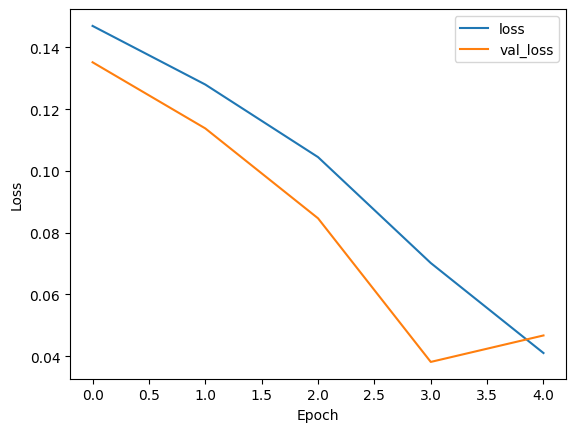

In [20]:
with open('../history/Wave_UNet_L1Loss.json','r') as f:
    history = json.load(f)

plt.plot(history["train_loss"], label="loss")
plt.plot(history["val_loss"], label="val_loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()